In [1]:
import pandas as pd
from keybert import KeyBERT
import re
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans

In [2]:
# Load and preprocess the data
data = pd.read_csv('../data/pyt_posts.csv')

In [3]:
# Remove duplicates
data.drop_duplicates(subset='Body', inplace=True)

In [4]:
# Function to remove code snippets
def remove_code_snippets(text):
    return re.sub('<code>[^>]+</code>', '', text)

# Function to remove hyperlinks
def remove_hyperlinks(text):
    return re.sub(r'http\S+|www.\S+', '', text)

# Function to remove non-alphanumeric characters and HTML tags
def clean_text(text):
    text = re.sub('<[^<]+?>', '', text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

In [5]:
# Apply preprocessing functions
data['cleaned_body'] = data['Body'].apply(remove_code_snippets)
data['cleaned_body'] = data['cleaned_body'].apply(remove_hyperlinks)
data['cleaned_body'] = data['cleaned_body'].apply(clean_text)

In [6]:
# Remove stopwords
stopwords = ['the', 'and', 'to', 'in', 'of', 'i', 'is', 'for', 'it', 'with', 'that', 'this', 'you', 'on', 'was', 'are', 'as', 'have', 'but', 'not']
data['cleaned_body'] = data['cleaned_body'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

In [7]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
data['stemmed_body'] = data['cleaned_body'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))
data['lemmatized_body'] = data['stemmed_body'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))

In [8]:
# Instantiate the KeyBERT model
model = KeyBERT('distilbert-base-nli-mean-tokens')

In [10]:
# Extract keywords for each post
data['topics'] = data['lemmatized_body'].apply(lambda x: [keyword[0] for keyword in model.extract_keywords(x, keyphrase_ngram_range=(1, 2))])

In [15]:
# Save the topics to a new file
data['topics'].to_csv('pytorch_topics.csv', index=False)

In [16]:
# Count the occurrence of each topic
topic_counts = {}
for topics in data['topics']:
    for topic in topics:
        topic_counts[topic] = topic_counts.get(topic, 0) + 1

Text(0.5, 1.0, 'Top 10 Topics in Stack Overflow Posts')

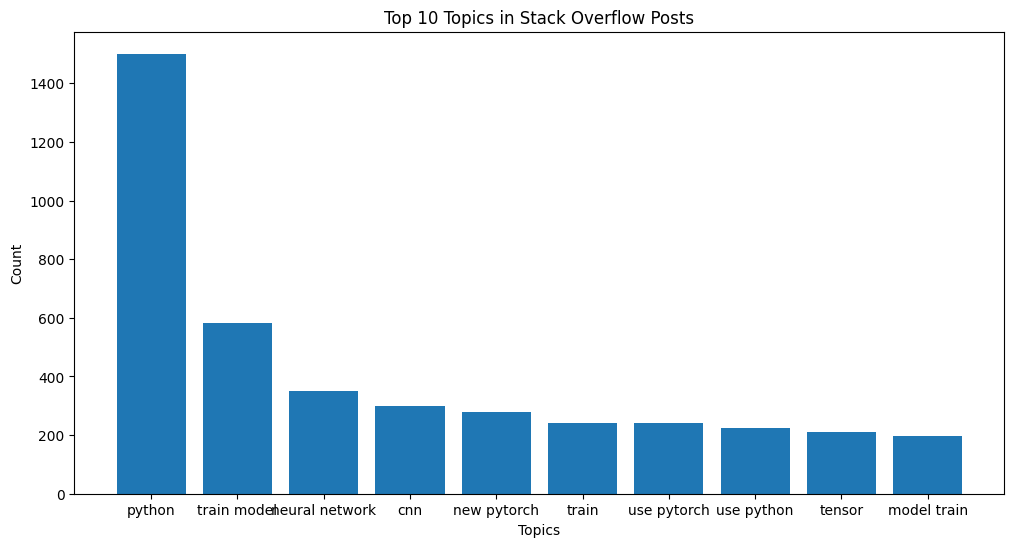

In [17]:
# Create a bar chart of the top 10 topics
top_topics = sorted(topic_counts.items(), key=lambda x: x[1], reverse=True)[:10]
topics, counts = zip(*top_topics)

plt.figure(figsize=(12, 6))
plt.bar(topics, counts)
plt.xlabel('Topics')
plt.ylabel('Count')
plt.title('Top 10 Topics in Stack Overflow Posts')

In [26]:
# Extract the keywords for each topic
topics = data['topics'].to_string().split(',')
topic_keywords = [model.extract_keywords(' '.join(topic)) for topic in topics]

In [30]:
# Perform K-means clustering
num_clusters = len(set(topic))
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(topics)
cluster_labels = kmeans.labels_

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 # Perform K-means clustering                                                                 │
│   2 num_clusters = len(set(topic))                                                               │
│   3 kmeans = KMeans(n_clusters=num_clusters, random_state=42)                                    │
│ ❱ 4 kmeans.fit(topics)                                                                           │
│   5 cluster_labels = kmeans.labels_                                                              │
│   6                                                                                              │
│                                                                                                  │
│ C:\Users\wgo027\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1417   │
│ in fit                                                                                           │
│                                                                                                  │
│   1414 │   │   """                                                                               │
│   1415 │   │   self._validate_params()                                                           │
│   1416 │   │                                                                                     │
│ ❱ 1417 │   │   X = self._validate_data(                                                          │
│   1418 │   │   │   X,                                                                            │
│   1419 │   │   │   accept_sparse="csr",                                                          │
│   1420 │   │   │   dtype=[np.float64, np.float32],                                               │
│                                                                                                  │
│ C:\Users\wgo027\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:565 in            │
│ _validate_data                                                                                   │
│                                                                                                  │
│    562 │   │   if no_val_X and no_val_y:                                                         │
│    563 │   │   │   raise ValueError("Validation should be done on X, y or both.")                │
│    564 │   │   elif not no_val_X and no_val_y:                                                   │
│ ❱  565 │   │   │   X = check_array(X, input_name="X", **check_params)                            │
│    566 │   │   │   out = X                                                                       │
│    567 │   │   elif no_val_X and not no_val_y:                                                   │
│    568 │   │   │   y = _check_y(y, **check_params)                                               │
│                                                                                                  │
│ C:\Users\wgo027\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:879   │
│ in check_array                                                                                   │
│                                                                                                  │
│    876 │   │   │   │   │   │   )                                                                 │
│    877 │   │   │   │   │   array = xp.astype(array, dtype, copy=False)                           │
│    878 │   │   │   │   else:                                                                     │
│ ❱  879 │   │   │   │   │   array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)   │
│    880 │   │   │   except ComplexWarning as complex_warning

In [ ]:
# Create a dictionary to store the categories
categories = {}
for i, label in enumerate(cluster_labels):
    category = categories.get(label, {'count': 0, 'keywords': []})
    category['count'] += 1
    category['keywords'] = list(set(category['keywords'] + topic_keywords[i]))
    categories[label] = category

In [ ]:
# Save each category to a new file
for label, category in categories.items():
    file_name = f'category_{label}.csv'
    category_data = data.loc[cluster_labels == label]
    category_data.to_csv(file_name, index=False)

    print(f'Category {label} - {category_data.shape[0]} posts')
    print('Keywords:', ', '.join(category['keywords']))
    print()